# Building a Price-Prediction model for Crypto-Currencies

The task is to create a predictive model of some kind to forecast an assets price movement.

# Input DATA

The input  data cointains a CSV file located on Amazon Web Service (AWS) S3 in the amir-practice bucket and publically accessible via http.

There are two csv files in the bucket and the one named "market_data.csv" consists of market data derived from exchange trades during 01-01-2018 through 02-19-2019 and aggregated at the daily level. The second file named "blockchain_data.csv" consists of blockchain data for a subset of the assets which is also aggregated at the daily level. A short description of the data structure and variable names is also provided in a text file called data_dictionary.docx 

Let's start by reading in the data from the AWS S3 bucket:

In [2]:
#importing the libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing the data from Amazon AWS-S3 public bucket
url = 'https://s3.amazonaws.com/amir-practice/market_data.csv'

df_market = pd.read_csv(url) 

df_market[:3] # first look at the DateFrame

,base_asset_id,quote_asset_id,epoch_ts,price_open,price_high,price_low,price_close,price_mean_a,price_std,price_vwap_a,price_vwap_h,cnt_total,volume_total,volume_high,volume_low,volume_mean_a,volume_std
0,Bitcoin_BTC_BTC,USDollar_USD_USD,2019-02-19 00:00:00+00,3932.714647,4093.592472,3841.540000,3947.838332,3982.976819,42.843054,3992.851593,3992.331372,505918,1.016199e+05,3.309573e+02,1.800000e-09,0.245708,1.312071
1,Cardano_ADA_ADA,USDollar_USD_USD,2019-02-19 00:00:00+00,0.046611,0.051831,0.044664,0.046850,0.047804,0.000686,0.047779,0.047767,89496,4.697049e+08,1.680672e+06,1.000000e-01,6162.362937,18885.346700
2,Dash_DASH_DASH,USDollar_USD_USD,2019-02-19 00:00:00+00,87.616371,91.952000,85.849339,88.389405,88.486393,0.926142,88.470100,88.459994,23643,3.341039e+04,2.255077e+02,1.000000e-08,1.737967,5.353673


# Cleaning the data, extracting BTC price, and plotting the timeseries

The first step in builing the prediction model is to examine the input data, check for missing values, and sort the order/index. From here on, I conduct all the analysis on bitcoin but the same approach/code can be applied to all the other assests included in the input file.

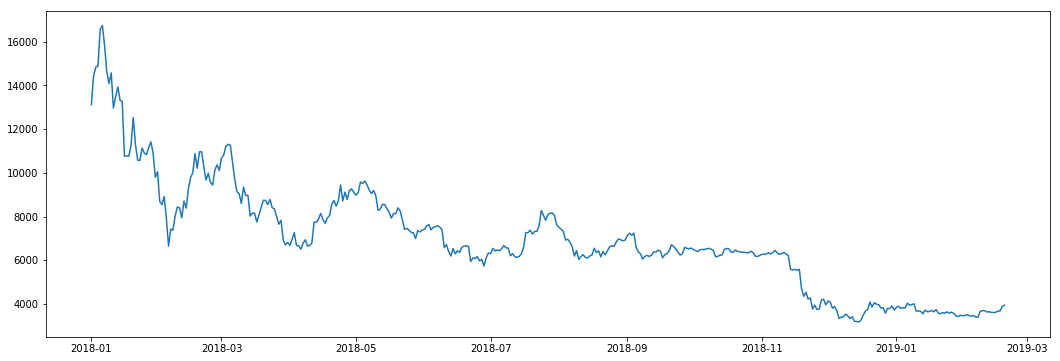

In [3]:
#df_market.shape, df_market.columns
df_btc = df_market[df_market['base_asset_id'] == 'Bitcoin_BTC_BTC'][::-1]

#setting date as index
df_btc['Date'] = pd.to_datetime(df_btc.epoch_ts,format='%Y-%m-%d')
df_btc.index = df_btc['Date']
df_btc_close = df_btc.loc[:,'price_close'].to_frame()

#plot
plt.figure(figsize=(18,6))
plt.plot(df_btc_close, label='Daily Close Price')

In [4]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.
/Applications/Anaconda/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


#  Converting the timeseries to a labeled dataframe for supervised learning

The timeserie of bitcoin price needs to be converted to a labeled format (such as X and Y) in order to be used in most ML models. For a univariate problem, the RNN model selected for price prediction (LSTM) uses an arbitrary number of previous time steps (n_lags) as the input to predict the price at the current time step. In our case, we choose n_lags=30 meaning that the LSTM model will use the price action of the last 30 days (t-30 to t-1) as its input variable X and the price at the current time step (t) as the output variable. Also both the input and output data need to be normalized to the (-1,1) scale before being used in the model.         

In [5]:
# convert timeseries to supervised learning ;Credit to Jason Brownlee @ machinelearningmastery.com
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#scaling the price data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_btc_close = scaler.fit_transform(df_btc_close)

# specify the number of lag timesteps
n_lags = 30
n_features = 1

# frame as supervised learning
labeled_btc = series_to_supervised(scaled_btc_close, n_lags, 1)
print(labeled_btc.shape)

(385, 31)


# Splitting the data into the train and test data

The entire length of data is split to a training (80%) and a testing (20%) period. The data is then reshaped to the 3D format of [samples, timelags, features] required for Keras LSTM model.

In [6]:
# split into train and test sets
input_values = labeled_btc.values
n_train = int(0.8 * (len(df_btc) - n_lags))
train = input_values[:n_train, :]
test = input_values[n_train:, :]

# split into input and outputs
n_obs = n_lags * n_features
X_train, y_train = train[:, :n_obs], train[:, -n_features]
X_test, y_test = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_lags, n_features))
X_test = X_test.reshape((X_test.shape[0], n_lags, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(308, 30, 1) (308,) (77, 30, 1) (77,)


# Building a RNNs Long Short-term Memory (LSTM) model

LSTM Recurrent Neural Networks are among powerful ML models for timeseries forecasting i.e. stock market price action. Here I build an LSTM model with Keras (Tensorflow backend) using the sequential stacking appraoch. The model structure has two hidden layers each with 50 neurons and an output layer with one neuron. The model is compiled using the Mean Squared Error as the loss function and the efficient Adam version of stochastic gradient descent as the optimization scheme. The model will be fit for a batch size of 7 and 50 training epochs.  

In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
log = model.fit(X_train, y_train, epochs=50, batch_size=7, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 308 samples, validate on 77 samples
Epoch 1/50
 - 7s - loss: 0.0182 - val_loss: 0.0086
Epoch 2/50
 - 4s - loss: 0.0047 - val_loss: 0.0068
Epoch 3/50
 - 4s - loss: 0.0047 - val_loss: 0.0064
Epoch 4/50
 - 4s - loss: 0.0043 - val_loss: 0.0056
Epoch 5/50
 - 4s - loss: 0.0039 - val_loss: 0.0048
Epoch 6/50
 - 4s - loss: 0.0036 - val_loss: 0.0040
Epoch 7/50
 - 3s - loss: 0.0033 - val_loss: 0.0033
Epoch 8/50
 - 3s - loss: 0.0031 - val_loss: 0.0027
Epoch 9/50
 - 3s - loss: 0.0028 - val_loss: 0.0022
Epoch 10/50
 - 4s - loss: 0.0026 - val_loss: 0.0018
Epoch 11/50
 - 3s - loss: 0.0024 - val_loss: 0.0016
Epoch 12/50
 - 4s - loss: 0.0023 - val_loss: 0.0013
Epoch 13/50
 - 4s - loss: 0.0021 - val_loss: 0.0012
Epoch 14/50
 - 3s - loss: 0.0020 - val_loss: 0.0010
Epoch 15/50
 - 4s - loss: 0.0019 - val_loss: 9.3022e-04
Epoch 16/50
 - 3s - loss: 0.0018 - val_loss: 8.2198e-04
Epoch 17/50
 - 3s - loss: 0.0017 - val_loss: 7.2173e-04
Epoch 18/50
 - 4s - loss: 0.0017 - val_loss: 6.2948e-04
Epoch 19/50


# Checking for over/under fitting

There are various ways to check if the model is overfitting or underfitting. Here I use the loss curve approach by plotting the training vs. validation loss curves along the epoch axis and comparing the two curves to one another. The general rule about loss curves is that if the training loss is much smaller than the validation loss, the model is overfitted to the training samples and performs poorly over the unseen test dataset. To face the overfitting issue, one can implement one or more of available options including adding a regularization method to the model (e.g. applying a drop out rate), reduce the complexity of the model structure (e.g. decrease the network size/layers or reduce the number of neurons), or if possible, use more data (increase the sample length) or include more features in the model.

On the other hand, if the training loss is about equal to the validiation loss then the model is underfitting. This can be dealt with by increasing the size/complexity of the model (i.e. adding more layers or increasing the number of neurons in the existing layers).

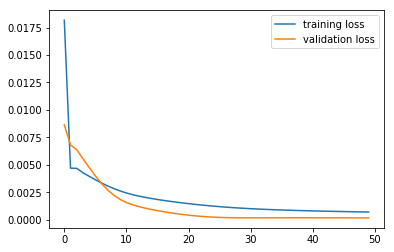

In [10]:
# plot history
plt.plot(log.history['loss'], label='training loss')
plt.plot(log.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In our case, both validation and training errors converge to small values through a relatively good learning rate yet  the validation error is slightly smaller than the training error. Usually, the validation error should be slightly higher in a good fit. In our model though, the difference is relatively small and the lower validation loss seems acceptable as the training period contains very hard cases (large price range/volatility) whereas the validation period contains relatively easy samples to predict. 

# Predicting Bitcoin price

The trained model is used to predict the price over the test period. The model prediction is in the scaled format ( between -1 and 1) thus needs to be rescaled back to the USD format. The results are plotted along with the actual price action during both the train and test periods. I also calculated the Root Mean Square Error (RMSE) between the observed and predicted prices to have an objective metric for evaluating the model bias. 

In [11]:
#  predicting the BTC close price over the test period
yhat_test = model.predict(X_test)
yhat_test = scaler.inverse_transform(yhat_test)

168.42662091988294

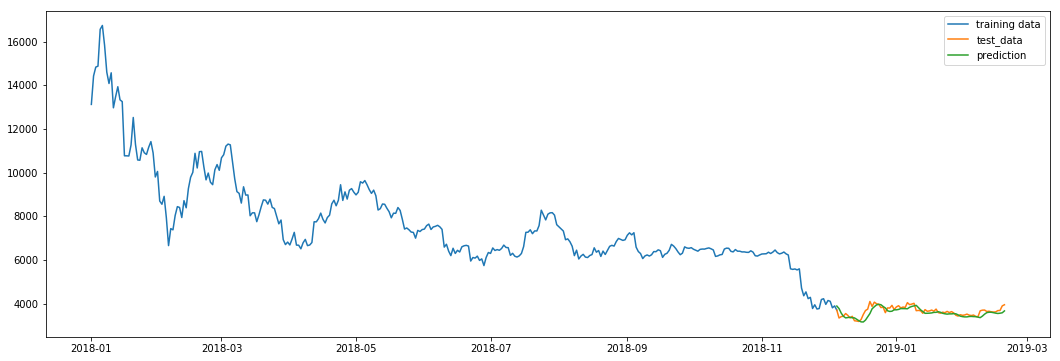

In [12]:
#Plotting the results

df_yhat_test = df_btc.loc[:, ['price_close']].tail(len(df_btc)-n_train-n_lags)
df_yhat_test['Prediction'] = np.array(yhat_test)

rmse=np.sqrt(np.mean(np.power((df_yhat_test['price_close']-df_yhat_test['Prediction']),2)))

plt.figure(figsize=(18,6))
plt.plot(df_btc_close[:(n_train+n_lags+1)], label='training data')
plt.plot(df_yhat_test['price_close'], label='test_data')
plt.plot(df_yhat_test['Prediction'], label='prediction')
plt.legend()

rmse

# Conclusion

Overall, the LSTM model looks promissing and the prediction errors are relatively small. However, the model could be further improved by using a much longer time period and also including additional features influencing bitcoin's price such as daily volume, transaction fees/counts, network hashrate, google trend results as a proxy for market sentiment, and etc. Including additional features requires upgrading the model from a univariate LSTM to a multivariate LSTM and the structure and complexity of the model may need addtional tuning/upgrade. 

The model developed here is built for bitcoin price prediction but it can be used to forecast the price of all other cryptocurrencies included in the input data. Given that the price of other crypto assets is strongly sensitive to bitcoin's price, the latter can be used as an additional feature in predicting the price of alternative coins/tokens. 